In [1]:
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.polynomial.polynomial import polyfit
import sys
import os
if 'dilithium_solver' not in sys.path:
    sys.path.append('dilithium_solver')
if 'python-dilithium' not in sys.path:
    sys.path.append('python-dilithium')
from dilithium import Dilithium
import dilithium_solver

In [2]:
d = Dilithium(2)
d.pseudorandombytes_seed(b'attack-shuffling-countermeasure-keypair')
pk, sk = d.keypair()
SECRET_KEY_PACKED = sk

In [3]:
def get_iter(poly_candidate: np.ndarray) -> bool:
    """
    0 = all coeffs zero; 1 - 63 = some non faulted in the beginning rest zero;
    64 = no fault; None = not our fault model (i.e. faults within iters)
    
    Be warned: results are less likely to be correct the higher the iteration
    """
    for i in range(0, d._polyz_unpack_num_iters + 1):
        if np.all(np.abs(poly_candidate[i * d._polyz_unpack_coeffs_per_iter:]) <= d.beta):
            return i
    return None

In [4]:
def json_sig(sig_list: [int]) -> (np.ndarray, np.ndarray, np.ndarray):
    sig = bytes(sig_list)
    return d._unpack_sig_full(sig)

In [5]:
def points_no_duplicates(point_l: [dict]):
    def is_equal(p1, p2):
        return p1
    [p for p in point_l if p]

In [6]:
files_all_sig = list(filter(lambda f: (f.startswith('sig') or f.startswith('allperfectFIXED')) and f.endswith('.json'), os.listdir()))
files_all_sig = list(map(lambda f: (f, os.path.getctime(f)), files_all_sig))
files_all_sig.sort(key=lambda x: x[1])
files_all_sig

[('sig_new_params53906894-0c24-4de0-8667-f3900b0d1674.json',
  1670813765.743504),
 ('sig_new_params5857711f-1c29-4369-90ee-c519ef8ee727.json',
  1670813981.1151772),
 ('sig_new_paramsfad4b6f2-cf25-4ce2-95b5-482acd806751.json',
  1670814025.8022838),
 ('sig_new_params01c520a0-df9d-40c7-aadb-496b3ee6028c.json',
  1670814029.9142017),
 ('sig_new_paramsf2f79f55-e54a-4543-90cb-aa4475e265e2.json',
  1670814032.6141477),
 ('sig_new_params6ade566b-93d5-4579-943d-dc9a0a59846e.json',
  1670814047.1898568),
 ('sig_new_params2f8b0939-a012-4d41-a9d6-c32f500c7af0.json',
  1670815285.4253685),
 ('sig_new_params02fb4e32-f06c-402c-b19d-4c0f23ace5e8.json',
  1670816801.540484),
 ('sig_new_paramsdbfdde2f-16f9-4cd8-96cb-3a5cf7bd9db8.json',
  1670821244.8491883),
 ('allperfectFIXEDbaddfc30-27a3-4259-a55f-d479e00489f0.json',
  1670869835.1522825)]

In [7]:
# alter files to be used here if wanted
files_selected = files_all_sig[5:] # the first 5 files do not have a compatible JSON format
files_selected

[('sig_new_params6ade566b-93d5-4579-943d-dc9a0a59846e.json',
  1670814047.1898568),
 ('sig_new_params2f8b0939-a012-4d41-a9d6-c32f500c7af0.json',
  1670815285.4253685),
 ('sig_new_params02fb4e32-f06c-402c-b19d-4c0f23ace5e8.json',
  1670816801.540484),
 ('sig_new_paramsdbfdde2f-16f9-4cd8-96cb-3a5cf7bd9db8.json',
  1670821244.8491883),
 ('allperfectFIXEDbaddfc30-27a3-4259-a55f-d479e00489f0.json',
  1670869835.1522825)]

In [8]:
data_points = []
for file in map(lambda f: f[0], files_selected):
    with open(file) as f:
        file_content = json.load(f)
        sig_correct = json_sig(file_content['sig_correct'])
        for i, (sig_faulted_list, params) in enumerate(zip(file_content['sigs_faulted'], file_content['sigs_faulted_params'])):
            sig_faulted_bytes = bytes(sig_faulted_list)
            sig_faulted = d._unpack_sig_full(sig_faulted_bytes)
            data_points.append({
                'sig_faulted_bytes': sig_faulted_bytes, # for easy equal checks
                'sig_correct': sig_correct,
                'sig_faulted': sig_faulted,
                'params': tuple(params),
                'iteration': get_iter(sig_faulted[1][0])
            })
len(data_points), "0 = ext_offset, 1 = offset, 2 = width"

(352, '0 = ext_offset, 1 = offset, 2 = width')

In [9]:
# check if the data points match with any of my simulations ...
predictions = []
rejections = []
successful_poly_indices = set()
for i in range(62):
    sig_packed, num_rejections = d.signature_faulted(b'\x00\x01', sk, 0, i)
    predictions.append(sig_packed)
    rejections.append(num_rejections)
for dp in data_points:
    sig_faulted = dp['sig_faulted_bytes']
    try:
        poly_index = predictions.index(sig_faulted)
        print(f"iteration {dp['iteration']} matches with poly_index {poly_index} ({rejections[poly_index]}), {dp['params']}")
        successful_poly_indices.update((poly_index,))
    except ValueError:
        pass
successful_poly_indices

iteration 5 matches with poly_index 4 (0), (299, 6.640625, 6.640625)
iteration 17 matches with poly_index 16 (0), (1043, 6.640625, 6.640625)
iteration 20 matches with poly_index 19 (0), (1229, 6.640625, 6.640625)
iteration 24 matches with poly_index 23 (0), (1477, 6.640625, 6.640625)
iteration 31 matches with poly_index 30 (0), (1911, 6.640625, 6.640625)
iteration 34 matches with poly_index 33 (0), (2097, 6.640625, 6.640625)
iteration 34 matches with poly_index 33 (0), (2097, 6.640625, 6.640625)
iteration 52 matches with poly_index 51 (0), (3213, 6.640625, 6.640625)
iteration 55 matches with poly_index 54 (0), (3399, 6.640625, 6.640625)
iteration 59 matches with poly_index 58 (0), (3647, 6.640625, 6.640625)
iteration 61 matches with poly_index 60 (0), (3771, 6.640625, 6.640625)
iteration 61 matches with poly_index 60 (0), (3771, 6.640625, 6.640625)


{4, 16, 19, 23, 30, 33, 51, 54, 58, 60}

In [10]:
data_perfect = []
num_total = defaultdict(lambda: 0) # total amount of fault attempts per params
num_perfect = defaultdict(lambda: 0) # total amount of perfect glitches for a parameter AND iteration

for point in data_points:
    params = point['params']
    extended_params = (params, point['iteration'])
    
    num_total[params] += 1
    if point['iteration'] is not None and point['iteration'] != d._polyz_unpack_num_iters:
        num_perfect[extended_params] += 1
        data_perfect.append(point)

for p in data_perfect:
    params = p['params']
    extended_params = (p['params'], p['iteration'])
    
    total = num_total[params]
    p['total'] = total
    p['perfect'] = num_perfect[extended_params]
len(data_perfect)

108

In [11]:
all_discovered_iterations = set()
for point in data_perfect:
    all_discovered_iterations.update([point['iteration']])
all_discovered_iterations, 1 / (len(all_discovered_iterations) / d._polyz_unpack_num_iters)

({3,
  5,
  7,
  8,
  15,
  17,
  18,
  19,
  20,
  24,
  25,
  27,
  28,
  31,
  33,
  34,
  40,
  42,
  44,
  48,
  49,
  50,
  52,
  53,
  55,
  58,
  59,
  60,
  61,
  62},
 2.1333333333333333)

In [12]:
def make_plot(dat, text: bool = False, lstsq: bool = False):
    iters = list(map(lambda p: p['iteration'], dat))
    ext_offsets = list(map(lambda p: p['params'][0], dat))
    rates = list(map(lambda p: p['perfect'] / p['total'], dat))
    totals = list(map(lambda p: p['total'], dat))

    fig = plt.figure()
    ax = fig.subplots()
    print(type(ax))
    #help(ax)
    ax.set_ylabel('ext_offset')
    ax.set_xlabel('polyz_unpack iteration')
    ax.set_title("msg = b'\\x00\\x01'; sk = b'attack-shuffling-countermeasure-keypair'")
    ax.grid(True)
    scatter = ax.scatter(iters, ext_offsets, c=np.array(rates), cmap='winter')
    cbar = plt.colorbar(scatter)
    cbar.set_label('success rate')
    if text:
        point_to_width_and_offset = defaultdict(lambda: set())
        for p in dat:
            point_to_width_and_offset[(p['iteration'], p['params'][0])].update(
                ['o={:.2f}|w={:.2f}|{}/{}'.format(p["params"][1], p["params"][2], p['perfect'], p['total'])]
            )
        for (iteration, ext_offset), offsets_and_widths in point_to_width_and_offset.items():
            ax.text(iteration, ext_offset, '\n'.join(offsets_and_widths), ha='center', fontsize='small', color='y')
            #print(offsets_and_widths)
            #print('\n'.join(offsets_and_widths))
            #break
        # commented out code below would print total of faults and the success rate for that offset
        # for iteration, ext_offset, total, rate in list(zip(iters, ext_offsets, totals, rates)):
        #     ax.text(iteration, ext_offset, f'{total}|{math.floor(rate * 100)}', ha='center', fontsize='small', color='y')
    if lstsq:
        b, m = polyfit(iters, ext_offsets, 1)
        linfunc = lambda x: b + x * m
        x = np.arange(np.min(iters), np.max(iters) + 1)
        plt.plot(x, b + m * x, '-', color='r')
        plt.scatter(x, b + m * x, facecolors='none', edgecolors='r', linewidths=.3)
        return b, m

<IPython.core.display.Javascript object>


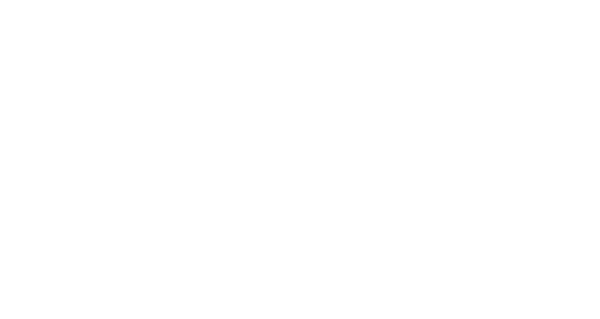

<class 'matplotlib.axes._subplots.AxesSubplot'>
lambda iteration: -73.06266362200604 + 62.34032986000754 * iteration


In [13]:
%matplotlib notebook
dat_plot = data_perfect
b, m = make_plot(dat_plot, False, True)
print(f'lambda iteration: {b} + {m} * iteration')

<IPython.core.display.Javascript object>


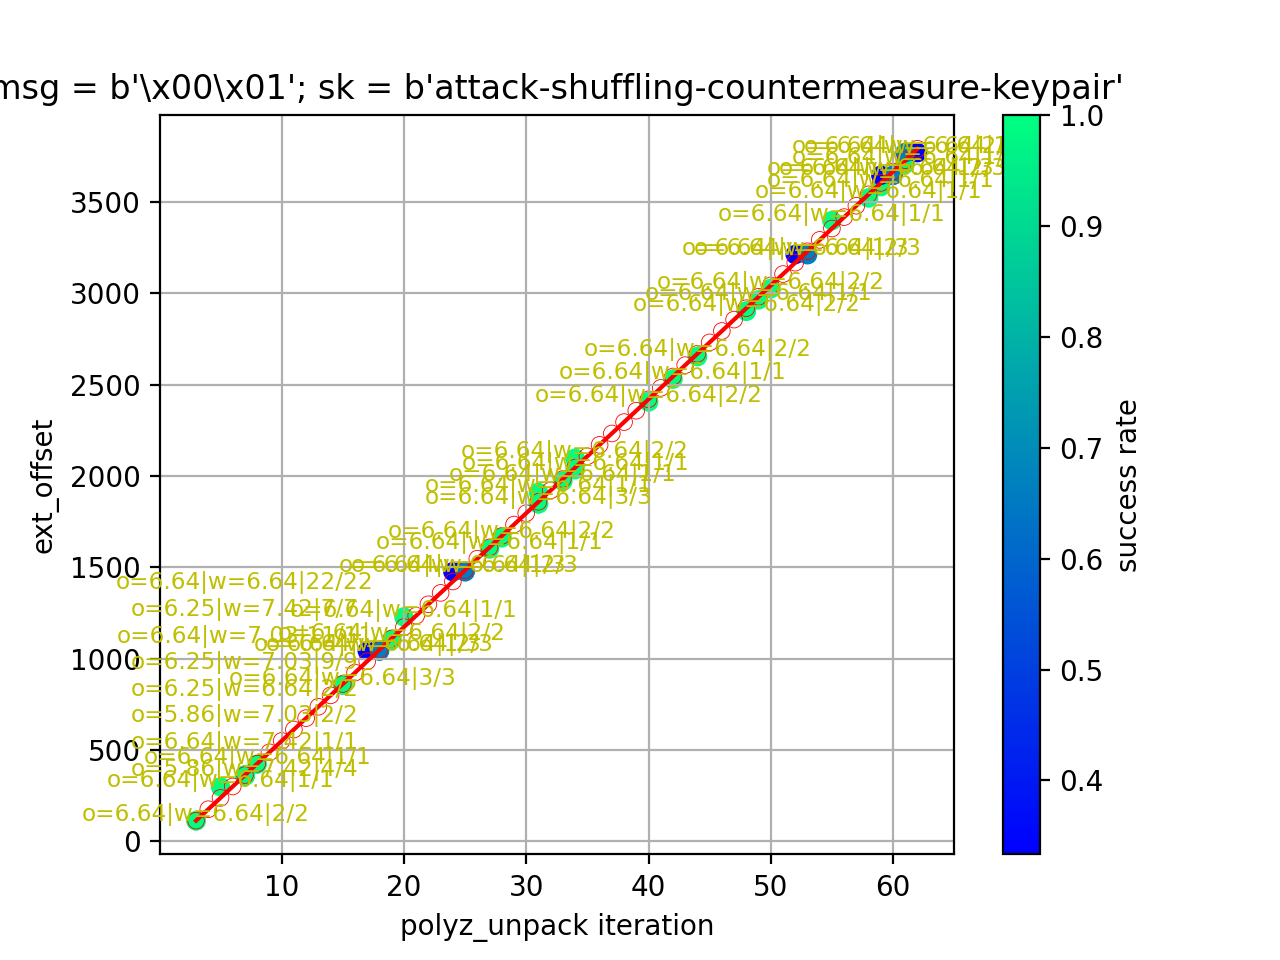

<class 'matplotlib.axes._subplots.AxesSubplot'>
lambda iteration: -73.06266362200604 + 62.34032986000754 * iteration


In [14]:
%matplotlib notebook
dat_plot = data_perfect
offset, slope = make_plot(dat_plot, True, True)
print(f'lambda iteration: {offset} + {slope} * iteration')

In [15]:
def point_on_line(offset, slope, point_x, point_y):
    return offset + point_x * slope == point_y

In [16]:
candidates = defaultdict(lambda: 0)
islope = math.ceil(slope)
ioffset = math.ceil(offset)

offset_to_point = {p['params'][0]: p for p in data_perfect}
perfect_unique_offset = offset_to_point.values()

for possible_slope in range(islope - 5, islope + 5):
    for possible_offset in range(ioffset - 100, ioffset + 100):
        for p in perfect_unique_offset:
            if point_on_line(possible_offset, possible_slope, p['iteration'], p['params'][0]):
                candidates[(possible_offset, possible_slope)] += 1
{k: v for (k, v) in candidates.items() if v > 1}

{(-73, 62): 23, (-11, 62): 6, (-79, 64): 2}

In [17]:
# 7 = 361
# 8 = 423
# diff = 62
# offset = -73
# => ext_offset = iter * 62 - 73

In [18]:
sigs_bytes = []
sigs = []
iterations = []
no_dupes = []
for p in data_perfect:
    #print(p['sig_faulted_bytes'])
    #break
    if p['sig_faulted_bytes'] not in sigs_bytes:
        sigs_bytes.append(p['sig_faulted_bytes'])
        sigs.append(p['sig_faulted'])
        iterations.append(p['iteration'])
        no_dupes.append({
            'sig_faulted': p['sig_faulted'],
            'iteration': p['iteration']
        })
num_zero_coefficients = sum(iterations) * d._polyz_unpack_coeffs_per_iter
#no_dupes = list(zip(sigs, iterations))
print(f'We have {d.n * len(iterations) - num_zero_coefficients} equations')
len(no_dupes)

We have 3776 equations


34

In [19]:
from dilithium_solver.signature import Signature, calculate_c_matrix_np
from dilithium_solver.recover_s_1_entry import recover_s_1_entry
from dilithium_solver.parameters import Parameters

params = Parameters.get_nist_security_level(2)

sigs = list(map(lambda p: Signature(
    p['sig_faulted'][1],
    p['sig_faulted'][0],
    calculate_c_matrix_np(p['sig_faulted'][0], params)
), no_dupes))
s_1_entry_index = 0
s_1 = d._unpack_sk(SECRET_KEY_PACKED)[4]
timeout = 60
threshold = d.beta
result = recover_s_1_entry(sigs, s_1_entry_index, s_1, params, num_zero_coefficients, timeout, threshold)
result

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-07
Set parameter TimeLimit to value 60
Set parameter Threads to value 4
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i7-6850K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 6 logical processors, using up to 4 threads

Optimize a model with 7696 rows, 4104 columns and 307840 nonzeros
Model fingerprint: 0x03853e64
Variable types: 0 continuous, 4104 integer (3848 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+05, 1e+05]
Found heuristic solution: objective 107.0000000
Presolve time: 0.26s
Presolved: 7696 rows, 4104 columns, 307840 nonzeros
Variable types: 0 continuous, 4104 integer (3848 binary)

Root relaxation: objective 3.848000e+03, 955 iterations, 0.73 seconds (0.96 work units)

    Nodes    |    Current Node    |  

(array([ 0.,  1.,  2., -2., -1., -1., -2.,  2., -2.,  2.,  2., -1.,  2.,
         1.,  0.,  2., -2.,  2.,  1., -1.,  0., -2.,  0.,  2.,  1., -1.,
        -2., -1.,  0.,  1., -2.,  1.,  0.,  2.,  0.,  1.,  0.,  0., -2.,
        -2., -2.,  1., -2.,  0.,  0., -2.,  0., -1., -2., -1.,  2.,  2.,
         1.,  2.,  1.,  0.,  1., -2.,  0., -2.,  1., -2.,  1., -2., -2.,
         2., -1.,  0., -2., -1.,  1.,  1.,  1.,  2., -2.,  1.,  0., -1.,
         0.,  2.,  1.,  0.,  2.,  1.,  2., -1.,  2.,  1.,  2.,  0., -1.,
        -1.,  2., -1., -1.,  1., -1.,  2., -1.,  1., -1.,  0., -1.,  1.,
         0.,  0., -2.,  0.,  2.,  1.,  1.,  0.,  2., -1., -1.,  2.,  1.,
         2.,  0., -1.,  1.,  0., -2.,  2., -2., -1., -2.,  1.,  0.,  0.,
         0.,  0.,  1.,  1., -1., -1.,  2., -1.,  0.,  2., -1., -2.,  2.,
         2.,  2., -1.,  0., -2.,  1.,  2.,  0.,  1.,  1.,  1.,  0., -1.,
         2.,  0., -2., -2.,  1., -1.,  1.,  2., -1.,  0.,  2.,  0., -2.,
        -1., -1.,  2.,  2.,  2., -1.,  0., -2.,  0.